In [1]:
!pip install pulp
!pip install yfinance
!pip install cvxpy
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pulp
import scipy.linalg as la
import yfinance as yf

### Selected stock

In [2]:

# Define the symbols for stocks and bonds
assets = ["EA", "MSFT", "NFLX", "GOOGL", "IGSB", "RYSE", "XBIL", "GC=F"]

# Fetch historical data for each symbol
data = {}
for symbol in assets:
    data[symbol] = yf.download(symbol, period="1y")

# Create a DataFrame to store the close prices
close_prices = pd.DataFrame(columns=assets)

# Populate the DataFrame with close prices
for symbol in assets:
    close_prices[symbol] = data[symbol]['Close']
close_prices.dropna(inplace=True)

# Display the DataFrame
print(close_prices)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                    EA        MSFT        NFLX       GOOGL       IGSB  \
Date                                                                    
2023-04-11  125.680000  282.829987  338.209991  105.349998  50.509998   
2023-04-12  126.129997  283.489990  331.029999  104.639999  50.560001   
2023-04-13  128.279999  289.839996  346.190002  107.430000  50.660000   
2023-04-14  127.870003  286.140015  338.630005  108.870003  50.529999   
2023-04-17  128.080002  288.799988  332.720001  105.970001  50.439999   
...                ...         ...         ...         ...        ...   
2024-04-04  129.559998  417.880005  617.140015  150.529999  51.080002   
2024-04-05  130.289993  425.519989  636.179993  152.500000  51.009998   
2024-04-08  130.000000  424.589996  628.409973  154.850006  50.950001   
2024-04-09  130.690002  426.279999  618.200012  156.600006  51.009998   
2024-04-10  129.300003  423.260010  618.580017  156.139999  50.720001   

                 RYSE       XBIL         GC=F  
Da

In [3]:
returns = {}
for symbol in close_prices.columns:
    close = close_prices[symbol].values
    T = 1  # Number of days in time period
    # Check if there are enough data points for calculation
    if len(close) > T:
        returns[symbol] = (close[T:] - close[:-T]) / close[:-T]

# Convert returns dictionary to DataFrame
R = pd.DataFrame(returns)
R.fillna(0, inplace=True)

# Display the returns DataFrame
print(R)

           EA      MSFT      NFLX     GOOGL      IGSB      RYSE      XBIL  \
0    0.003580  0.002334 -0.021229 -0.006739  0.000990 -0.000584  0.000200   
1    0.017046  0.022399  0.045796  0.026663  0.001978  0.006625  0.000399   
2   -0.003196 -0.012766 -0.021838  0.013404 -0.002566  0.009253 -0.000199   
3    0.001642  0.009296 -0.017453 -0.026637 -0.001781  0.011930  0.000000   
4    0.007495 -0.001489  0.002945 -0.013872  0.000198 -0.002843  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
246 -0.022336 -0.006113 -0.020537 -0.028337  0.000784 -0.005019  0.000801   
247  0.005634  0.018283  0.030852  0.013087 -0.001370  0.016652  0.000000   
248 -0.002226 -0.002186 -0.012214  0.015410 -0.001176  0.004518  0.000000   
249  0.005308  0.003980 -0.016247  0.011301  0.001178 -0.012129  0.000000   
250 -0.010636 -0.007085  0.000615 -0.002937 -0.005685  0.035857  0.000100   

         GC=F  
0    0.003043  
1    0.015118  
2   -0.019155  
3   -0.0039

In [4]:
r = R.mean()

# Display the mean return for each symbol
print("Mean Return for Each Symbol:")
print(r)

Mean Return for Each Symbol:
EA       0.000176
MSFT     0.001702
NFLX     0.002652
GOOGL    0.001716
IGSB     0.000019
RYSE     0.000094
XBIL    -0.000012
GC=F     0.000627
dtype: float64


In [5]:
# Compute covariance between each symbol
S = np.cov(R.T)

# Display the covariance matrix
print("Covariance Matrix:")
print(S)

Covariance Matrix:
[[ 1.24913550e-04  3.88965376e-05  4.02126633e-05  3.79564600e-05
   2.34632652e-06 -8.88397020e-06 -2.47731611e-07  7.12599673e-07]
 [ 3.88965376e-05  1.90349092e-04  1.22112322e-04  9.89474343e-05
   1.11349563e-06  4.66047021e-06 -6.32001423e-07 -4.35324088e-06]
 [ 4.02126633e-05  1.22112322e-04  5.03095045e-04  1.14351464e-04
   8.19450062e-06 -1.20940977e-05 -6.95216801e-07  9.36484953e-06]
 [ 3.79564600e-05  9.89474343e-05  1.14351464e-04  2.93251399e-04
   4.15295237e-06 -5.74052646e-06 -2.25096133e-07 -5.61400839e-06]
 [ 2.34632652e-06  1.11349563e-06  8.19450062e-06  4.15295237e-06
   4.08689619e-06 -1.64084785e-05  6.22650425e-07  5.71705477e-06]
 [-8.88397020e-06  4.66047021e-06 -1.20940977e-05 -5.74052646e-06
  -1.64084785e-05  2.32413297e-04 -7.24634137e-07 -2.72525465e-05]
 [-2.47731611e-07 -6.32001423e-07 -6.95216801e-07 -2.25096133e-07
   6.22650425e-07 -7.24634137e-07  8.99136718e-07 -1.16687762e-07]
 [ 7.12599673e-07 -4.35324088e-06  9.36484953e-06 

## Model 1A

In [6]:
from pulp import *
import numpy as np

# Define the data
n = len(assets)  # Number of assets
T = len(R)  # Number of time periods
r0 = 0.0008

# Define returns and covariance
R = R.values
S = np.cov(R.T)
r = r.values

# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += -(1 / T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("Expected Return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a7a15c7a4fd24d9abb479043b348ad82-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/a7a15c7a4fd24d9abb479043b348ad82-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 5295 RHS
At line 5800 BOUNDS
At line 5801 ENDATA
Problem MODEL has 504 rows, 259 columns and 4534 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 500 (-4) rows, 259 (0) columns and 4498 (-36) elements
Perturbing problem by 0.001% of 0.0052478416 - largest nonzero change 4.9862267e-05 ( 22.039575%) - largest zero change 4.0815415e-05
0  Obj -0 Primal inf 0.96866049 (2)
37  Obj -0.00075879763 Primal inf 184.2485 (232)
90  Obj -0.0016616802 Primal inf 817.53222 (242)
141  Obj -0.0026822396 Primal inf 142.6309 (200)
189  Obj -0.0031866711

## Model 1B

In [7]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
m0 = 0.007

# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t],
        f"Upper_constraint_{t}",
    )
    prob += (
        lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t],
        f"Lower_constraint_{t}",
    )

prob += (1 / T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("Expected Return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/44fc56e17cde4317a2dea1a132929f2d-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/44fc56e17cde4317a2dea1a132929f2d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 5295 RHS
At line 5800 BOUNDS
At line 5801 ENDATA
Problem MODEL has 504 rows, 259 columns and 4777 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 500 (-4) rows, 259 (0) columns and 4741 (-36) elements
Perturbing problem by 0.001% of 0.0052032367 - largest nonzero change 0.00011908808 ( 34.093615%) - largest zero change 9.9715536e-05
0  Obj -0 Primal inf 14.559002 (2) Dual inf 0.019251242 (7)
70  Obj 0.0035152096 Primal inf 561.48585 (227)
110  Obj 0.0021388135 Primal inf 1283.9988 (209)
154  Obj 0.0015653443 Primal inf 84.25708 (149)


### Model 1C

In [8]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:, 0])  # Number of time periods
mu = 1

# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)) * mu - (1 / T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("Expected Return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value((1 / T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5f9cf899424440e1b444d1b1e1137f9d-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/5f9cf899424440e1b444d1b1e1137f9d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 508 COLUMNS
At line 5294 RHS
At line 5798 BOUNDS
At line 5799 ENDATA
Problem MODEL has 503 rows, 259 columns and 4526 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 499 (-4) rows, 259 (0) columns and 4490 (-36) elements
Perturbing problem by 0.001% of 0.0052478416 - largest nonzero change 8.1673258e-05 ( 23.502247%) - largest zero change 0
0  Obj -0 Primal inf 0.18010583 (1) Dual inf 0.019443111 (7)
60  Obj -0.00012175978 Primal inf 249.7229 (239)
115  Obj -0.00028981883 Primal inf 20.383546 (228)
158  Obj -0.00034308998 Primal inf 18.911793 (192)
209  

In [18]:
#Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods

m0_array = np.linspace(0.0,0.01,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  # Define the data
  n = len(assets)  # Number of assets
  T = len(R[:,0])  # Number of time periods
  r0 = m0_array[i]

  # Create a LP problem
  prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

  # Define decision variables
  x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
  y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

  # Define objective function
  prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

  # Define constraints
  for t in range(T):
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

  prob += lpSum(r[j] * x[j] for j in range(n)) == r0

  prob += lpSum(x) == 1, "Sum_of_weights"

  # Solve the problem
  prob.solve()
  risk_array[i] = value( (1/T) * lpSum(y[t] for t in range(T)))

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/353aeb89801f4e318fa2c7392a2694ba-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/353aeb89801f4e318fa2c7392a2694ba-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 5295 RHS
At line 5800 BOUNDS
At line 5801 ENDATA
Problem MODEL has 504 rows, 259 columns and 4534 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 500 (-4) rows, 259 (0) columns and 4498 (-36) elements
Perturbing problem by 0.001% of 0.0052478416 - largest nonzero change 4.9862267e-05 ( 22.039575%) - largest zero change 4.0815415e-05
0  Obj -3.8894478e-08 Primal inf 0.48473967 (253)
36  Obj -0.00017697584 Primal inf 39.198197 (245)
85  Obj -0.00028206309 Primal inf 50.879442 (221)
136  Obj -0.00035094237 Primal inf 16.240804 (190)
190 

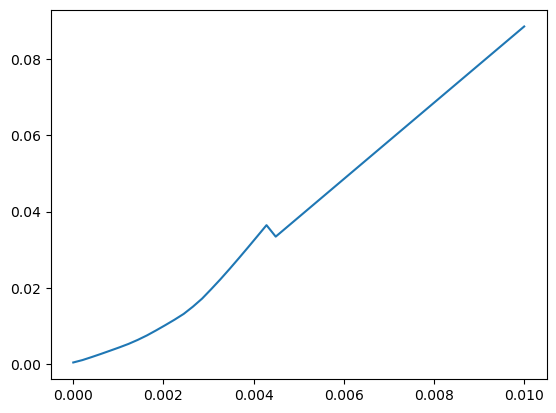

In [19]:
plt.figure()
plt.plot(m0_array, risk_array)

### Model 2A

In [12]:
import cvxpy as cp
import numpy as np

# Define the data
R_c = R - r.reshape(1, -1)
sig = np.dot(R_c.T, R_c) / T
r0 = 0.0005
n = len(R[0, :])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

# Define the optimization variables
X = cp.Variable((n, 1))

# Define the objective function
Objective = cp.Minimize(cp.quad_form(X, sig))

# Define the constraints
constraints = [e.T @ X == 1, X >= 0, rq.T @ X >= r0]

# Formulate the optimization problem
problem = cp.Problem(Objective, constraints)

# Solve the problem
result = problem.solve()

# Print the results
print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )
print("Mean std:", (X.value.T @ sig @ X.value)[0]**0.5 )

expected portfolio [[-2.97100644e-17  9.40237726e-02  4.89534915e-02  4.94599313e-02
  -2.68322312e-17  3.64858501e-02  5.66041700e-01  2.05035255e-01]]
expected return : [0.0005]
Mean variance: [8.48538201e-06]
Mean std: [0.00291297]


### Model 2B

In [13]:
# Calculate centered returns
R_c = R - r.reshape(1, -1)

# Compute covariance matrix manually
sig = np.dot(R_c.T, R_c) / T

# Define the parameters for the optimization problem
v0 = 0.0003
n = len(R[0])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

# Define decision variables
X = cp.Variable((n, 1))

# Define the objective function
Objective = cp.Maximize(rq.T @ X)

# Define the constraints
constraints = [e.T @ X == 1, X >= 0, cp.quad_form(X, sig) <= v0]

# Formulate the optimization problem
problem = cp.Problem(Objective, constraints)

# Solve the problem
result = problem.solve()

# Display the results
print("Expected Portfolio Weights:", X.value.T)
print("Expected Return:", (rq.T @ X.value)[0])
print("Mean Variance:", (X.value.T @ sig @ X.value)[0])
print("Mean Std:", np.sqrt((X.value.T @ sig @ X.value)[0]))

Expected Portfolio Weights: [[2.55202959e-07 1.86243095e-01 6.80119673e-01 1.33635583e-01
  2.47486147e-07 2.92451880e-07 2.46472241e-07 6.07187340e-07]]
Expected Return: [0.00235014]
Mean Variance: [0.0003]
Mean Std: [0.0173205]


/opt/conda/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


### Model 2C

In [14]:
# Calculate centered returns
R_c = R - r.reshape(1, -1)

# Compute covariance matrix manually
sig = np.dot(R_c.T, R_c) / T

# Define parameters for the optimization problem
mu = 0.1
n = len(R[0])
e = np.ones((n, 1))
rq = r.reshape(n, 1)

# Define decision variables
X = cp.Variable((n, 1))

# Define the objective function
Objective = cp.Maximize(mu * rq.T @ X - cp.quad_form(X, sig))

# Define the constraints
constraints = [e.T @ X == 1, X >= 0]

# Formulate the optimization problem
problem = cp.Problem(Objective, constraints)

# Solve the problem
result = problem.solve()

# Display the results
print("Expected Portfolio Weights:", X.value.T)
print("Expected Return:", (rq.T @ X.value)[0])
print("Mean Variance:", (X.value.T @ sig @ X.value)[0])
print("Mean Std:", np.sqrt((X.value.T @ sig @ X.value)[0]))

Expected Portfolio Weights: [[1.86193055e-23 2.48716332e-01 1.50858957e-01 1.31692003e-01
  9.09695618e-24 4.08690308e-02 5.67986999e-24 4.27863677e-01]]
Expected Return: [0.00132153]
Mean Variance: [5.78044909e-05]
Mean Std: [0.00760293]


In [15]:
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T

n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
e = np.ones((n,1))
rq = r.reshape(n,1)

m0_array = np.linspace(0.0005,0.0025,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  r0 = m0_array[i]

  X = cp.Variable((n,1))
  Objective = cp.Minimize(cp.quad_form(X,sig))
  constraints = [e.T@X == 1, X >= 0, rq.T@X == r0]
  problem = cp.Problem(Objective,constraints)

  result = problem.solve()

  risk_array[i] = (X.value.T @ sig @ X.value)[0,0]**0.5

#print("Status:", LpStatus[prob.status])
#print("Optimal Portfolio Weights:")
#for j in range(n):
    #print(f"x{j}: {value(x[j])}")
#print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
#print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


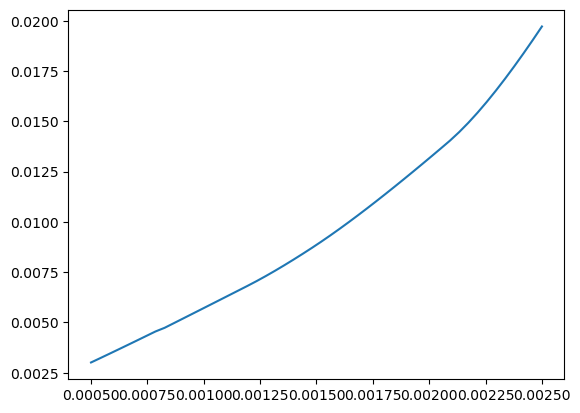

In [16]:
plt.figure()
plt.plot(m0_array, risk_array)